# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve Tiny ImageNet image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 25% (50% points)
    * 30% (60% points)
    * 32.5% (70% points)
    * 35% (80% points)
    * 37.5% (90% points)
    * 40% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 40%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the anytask atttachments). After that, you can use whatever you want.
* you __can't__ do anything with validation data apart from running the evaluation procedure. Please, split train images on train and validation parts

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
   
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.ImageFolder(root=path_to_tiny_imagenet, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    ```
   
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * [Albumentations](https://github.com/albumentations-team/albumentations) is another awesome solution.
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.  
    * But sometimes there is! Some examples of advanced image augmentation approaches: [mixup](https://arxiv.org/pdf/1710.09412.pdf), [cutmix](https://arxiv.org/pdf/1905.04899.pdf)   

In [1]:
#!L

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision, torchvision.transforms as transforms

# Uncomment this to disable "Skipping walk through <class 'list'>" warnings in DataSphere's env

%enable_full_walk

In [2]:
#!L

# downloading TinyImagenet
# you don't have to run this cell more than once

from tiny_img import download_tinyImg200, fix_test_data
data_path = '.'
download_tinyImg200(data_path)
fix_test_data(data_path)

./tiny-imagenet-200.zip


We will split `tiny-imagenet-200/train` dataset into train and val parts, and use  `tiny-imagenet-200/val` dataset as a test one.

You are free to use either the default ImageFolder Dataset, or the custom one, which will read and store the whole data in RAM. The second one is preferable only when you have a slow disk; make sure then you do have an extra couple of GiBs of memory (it also could take some time to load the images):

In [4]:
#!L

import os
imagenet_dir = os.path.join(data_path, 'tiny-imagenet-200')
dataset = torchvision.datasets.ImageFolder(imagenet_dir + '/train', transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000],
                                                           generator=torch.Generator().manual_seed(42))
test_dataset = torchvision.datasets.ImageFolder(imagenet_dir + '/val', transform=transforms.ToTensor())

# OR

# from tiny_img_ram import TinyImagenetRAM
# dataset = TinyImagenetRAM('tiny-imagenet-200/train', transform=transforms.ToTensor())
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [80000, 20000],
#                                                            generator=torch.Generator().manual_seed(42))
# test_dataset = TinyImagenetRAM('tiny-imagenet-200/val', transform=transforms.ToTensor())

In [5]:
#!L

batch_size = 1000

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

torch.Size([3, 64, 64])


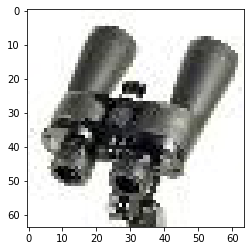

In [6]:
#!L

X, y = train_dataset[0]
print(X.shape)

x_img = np.zeros((64,64,3))
x_img[:,:,0] = X[0]
x_img[:,:,1] = X[1]
x_img[:,:,2] = X[2]


plt.imshow(x_img)
plt.show()

In [7]:
#!L

def compute_accuracy(data):
    epoch_accuracy = []
    for X_batch, y_batch in data:
        logits = model(Variable(torch.FloatTensor(X_batch)).to(device))
        y_pred = logits.max(1)[1].data
        epoch_accuracy.append((y_batch.cpu() == y_pred.cpu()).numpy())
    return np.mean(epoch_accuracy)

In [8]:
#!L

def compute_loss(X_batch, y_batch):
    X_batch = torch.FloatTensor(X_batch).to(device=device)
    y_batch = torch.LongTensor(y_batch).to(device=device)
    logits = model.to(device)(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [20]:
#!L

# feel free to copypaste code from seminar03 as a basic template for training
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
    
            nn.MaxPool2d(kernel_size=2), #32
    
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
    
            nn.MaxPool2d(kernel_size=2), #16
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
    
            nn.MaxPool2d(kernel_size=2), #8
    
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
    
            nn.MaxPool2d(kernel_size=2), #4
    
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
    
            nn.MaxPool2d(kernel_size=2), #2
    
            nn.Flatten(),
            nn.Linear(512*2*2, 200)
    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters())

device

device(type='cuda', index=0)

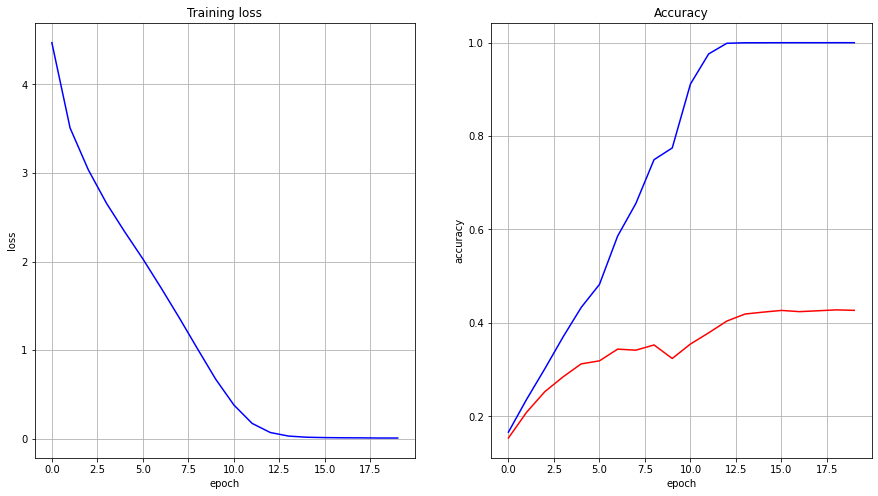

Task is done, waiting for foreground cells to finish...
Merging task result to the state


Cannot apply result: following variables are changed in this cell and need manual merge: X_batch, fig, training_accuracy, training_loss, losses, val_accuracy, loss, optimizer, y_batch, ax, model
To apply changes run: %apply_state d259a9c4-9b02-4b6f-ba3e-479f31417b9a/0f758e03-a2c8-4519-b13f-d44ac2a5de0b

In [21]:
#pragma async
#!L

from torch.autograd import Variable
from IPython import display


training_loss = []
training_accuracy = []
val_accuracy = []

epochs = 20

for epoch in range(epochs):
    model.train(True)
    losses = []
    for X_batch, y_batch in train_batch_gen:
        loss = compute_loss(X_batch, y_batch)
        losses.append(loss.cpu().data.numpy())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    training_loss.append(np.mean(losses))
    model.train(False)

    training_accuracy.append(compute_accuracy(train_batch_gen))
    val_accuracy.append(compute_accuracy(val_batch_gen))
    
    display.clear_output(True)
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))

    ax[0].set_title("Training loss")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].plot(training_loss, "b")
    ax[0].grid()

    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].plot(training_accuracy, c="b", label="train")
    ax[1].plot(val_accuracy, c="r", label="val")
    ax[1].grid()

    plt.show()

In [ ]:
%apply_state d259a9c4-9b02-4b6f-ba3e-479f31417b9a/0f758e03-a2c8-4519-b13f-d44ac2a5de0b

In [23]:
#!L

test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)
test_accuracy = compute_accuracy(test_batch_gen)

In [24]:
#!L

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 40:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 35:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 30:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 25:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		42.85 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

Лень писать на английском, поэтому напишу на русском. 

Написать сеточку с точностью более 0.40 было сложно, но спустя несколько бессоных (для дата сферы) ночей у меня получилось.

Итак, сначала я поискала в интернете статьи, как же обучают сетку для заданного датасета. Самой полезной оказалась [эта](http://cs231n.stanford.edu/reports/2015/pdfs/leonyao_final.pdf). Моя сетка состоит из нескольких сверточных слоев с применением функции активации ReLU и линейного слоя. В качестве критерия используется кросс-энтропия, которая включает в себя функцию активации log_softmax и nll_loss. В качестве оптимизатора был использован Adam. Выводы, к которым я пришла в процессе обучения:
1) Чем больше сверток, тем лучше становится сетке  
2) Использование BatchNorm увеличивает производительность и точность  
3) В части нейросеток Dropout также увеличивал точность, но в конечной я не использовала этот слой  

Во время обучения я столкнулась с проблемой, что не хватало памяти, поэтому были добавлены слои MaxPool. Также я пыталась использовать AvgPool, но в одной сетке это привело к падению точности, поэтому пришлось отойти от этой идеи. Кроме того моя сетка сильно переобучена и хочется это исправить. Также было бы неплохо поэкспериментировать с аугментацией. А что же радует? Сетка обучилась с нуля до точности > 0.4 на тестовой выборке.